# Exploratory Data Analysis
This notebook contains exploratory data analysis for the credit risk model.

In [84]:
%reload_ext autoreload

In [1]:
import sys
import os

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))
from scripts.count_words import count_words
from scripts.clean_text import clean_text

In [4]:
# Get the current working directory (where the notebook is located)
notebook_dir = os.getcwd()

# Get the project root directory (one level up from notebooks)
project_root = os.path.dirname(notebook_dir)


In [5]:
# Basic data loading and exploration will go here
print('EDA notebook ready for use')

# Path to your data file (adjust 'data' and 'complaints.csv' as needed)
data_path = os.path.join(project_root, 'data', 'complaints.csv')

df = pd.read_csv(data_path)

EDA notebook ready for use


/tmp/ipykernel_56149/916488450.py:7: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [ ]:
custom_percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

df['word_count'] = df['Consumer complaint narrative'].apply(count_words)

narratives_for_percentiles = df[df['word_count'] > 0]['word_count']
if not narratives_for_percentiles.empty:
    word_count_percentiles = narratives_for_percentiles.quantile(custom_percentiles)

    print("--- Percentiles of Narrative Word Count (Excluding 0-word narratives) ---")
    for p in custom_percentiles:
        # Use .get() with a default value in case a percentile falls on an empty range (e.g., if there are very few unique values)
        percentile_value = word_count_percentiles.get(p, 'N/A')
        # Check if the value is numeric before formatting
        if isinstance(percentile_value, (int, float)):
            print(f"{p * 100:.1f}%: {percentile_value:.0f} words")
        else:
            print(f"{p * 100:.1f}%: {percentile_value}")


    print("\n--- Counts of Narratives within Word Count Percentile Ranges ---")

    # Define the bins based on the calculated percentiles
    # Start with 0 and ensure the last bin covers the max word count
    bins = [0] + word_count_percentiles.tolist()
    # Add a value greater than the maximum word count to ensure the last bin captures everything up to max
    bins.append(df['word_count'].max() + 1)
    
    # Ensure bins are unique and sorted to avoid issues with pd.cut
    # If multiple percentiles resolve to the same value, remove duplicates
    bins = sorted(list(set(bins)))

    # Create labels for the bins to ensure clarity in output
    labels = []
    # Adjusting labels for the actual intervals created by pd.cut to avoid issues with identical percentile values
    # For pd.cut, intervals are typically (left, right].
    # We will let pd.cut generate its own labels for simplicity with complex bin scenarios,
    # then iterate through them to print counts.
    # Alternatively, you can define labels like this:
    for i in range(len(bins) - 1):
        lower = bins[i]
        upper = bins[i+1]
        # Handle cases where percentiles are identical (e.g., many 1-word entries)
        if lower == upper:
            # This bin might be empty or problematic with right=False, but pd.cut handles it.
            # We'll rely on the actual categories generated by pd.cut for printing.
            pass # We won't generate a label for identical consecutive bins here, pd.cut will.
        elif i == len(bins) - 2: # Last bin goes up to max
            labels.append(f"> {lower:.0f} words")
        else:
            labels.append(f"{lower:.0f} - <{upper:.0f} words")

    # Use pd.cut to categorize the word_count into these bins
    # 'right=False' means the bin includes the left edge, but not the right.
    # 'include_lowest=True' ensures values equal to the lowest bin edge are included.
    # We apply this to the full 'df['word_count']', then filter out 0-word counts.
    df['word_count_bin'] = pd.cut(df['word_count'], bins=bins, labels=labels if len(labels) == len(bins) -1 else None, right=False, include_lowest=True)

    # Filter out 0-word counts from the binning result, as these were excluded from percentile calculation
    actual_narratives_binned = df[df['word_count'] > 0]['word_count_bin']

    # Calculate counts for each bin
    bin_counts_series = actual_narratives_binned.value_counts().sort_index()

    # Print counts for each bin. It's often clearer to iterate through the bins
    # generated by pd.cut's categories, as they reflect the *actual* bins formed.
    print_categories = actual_narratives_binned.cat.categories
    for category in print_categories:
        count = bin_counts_series.get(category, 0)
        # Format the category label more nicely if it's an Interval
        if isinstance(category, pd.Interval):
            if category.left == category.right: # Handle cases like (1.0, 1.0]
                print(f"Exactly {category.left:.0f} words: {count} complaints")
            else:
                # Adjust for display based on pd.cut's right=False
                upper_display = category.right - (1 if category.right > category.left else 0) # Adjust for inclusive display
                print(f"{category.left:.0f} - {upper_display:.0f} words: {count} complaints")
        else:
            print(f"{category}: {count} complaints")

    print(f"\nTotal complaints with non-zero word count for binning: {actual_narratives_binned.count()}")
    print(f"Total complaints in simulated data: {len(df)}")
    print(f"Complaints with 0 words (e.g., NaN or empty after strip): {df[df['word_count'] == 0].shape[0]}")

else:
    print("No narratives with word count > 0 found to calculate percentiles and counts per range.")


--- Percentiles of Narrative Word Count (Excluding 0-word narratives) ---
1.0%: 11 words
5.0%: 22 words
10.0%: 33 words
25.0%: 59 words
50.0%: 114 words
75.0%: 209 words
90.0%: 364 words
95.0%: 519 words
99.0%: 1021 words

--- Counts of Narratives within Word Count Percentile Ranges ---
0 - <11 words: 27685 complaints
11 - <22 words: 117745 complaints
22 - <33 words: 148506 complaints
33 - <59 words: 442757 complaints
59 - <114 words: 749423 complaints
114 - <209 words: 744435 complaints
209 - <364 words: 451363 complaints
364 - <519 words: 149660 complaints
519 - <1021 words: 118495 complaints
> 1021 words: 30687 complaints

Total complaints with non-zero word count for binning: 2980756
Total complaints in simulated data: 9609797
Complaints with 0 words (e.g., NaN or empty after strip): 6629041


In [8]:
print(f"Number of rows: {len(df)}")
print("First 5 rows:")
print(df.head())

Number of rows: 9609797
First 5 rows:
  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Attempts to collect debt not owed   
2         Credit reporting           Improper use of your report   
3         Credit reporting           Improper use of your report   
4         Credit reporting  Incorrect information on your report   

                                       Sub-issue Consumer complaint narrative  \
0            Information belongs to someone else   

In [9]:
print("columns")
print(df.columns)

columns
Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')


In [10]:
print("Data types and missing values")
print(df.info())

# Summary statistics
print("Summary statistics")
print(df.describe(include='all'))

Data types and missing values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1),

In [11]:
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        839522
Consumer complaint narrative    6629041
Company public response         4770207
Company                               0
State                             54516
ZIP code                          30228
Tags                            8981029
Consumer consent provided?      1649561
Submitted via                         0
Date sent to company                  0
Company response to consumer         20
Timely response?                      0
Consumer disputed?              8841498
Complaint ID                          0
dtype: int64


In [12]:
print(df['Product'].unique())

['Credit reporting or other personal consumer reports' 'Debt collection'
 'Credit card' 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Debt or credit management' 'Mortgage'
 'Payday loan, title loan, personal loan, or advance loan' 'Prepaid card'
 'Student loan' 'Credit reporting'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit card or prepaid card' 'Payday loan, title loan, or personal loan'
 'Bank account or service' 'Money transfers' 'Consumer Loan' 'Payday loan'
 'Other financial service' 'Virtual currency']


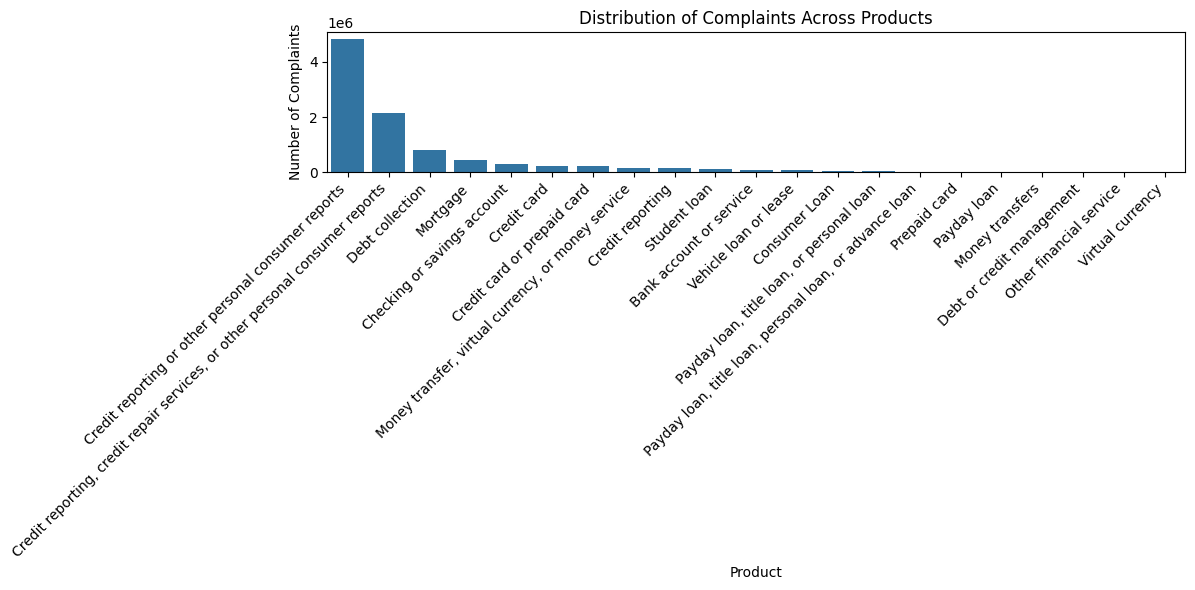


Product distribution:
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
V

In [6]:
plt.figure(figsize=(12, 6))
product_distribution = df['Product'].value_counts()

sns.barplot(x=product_distribution.index, y=product_distribution.values)
plt.title('Distribution of Complaints Across Products')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\nProduct distribution:")
print(product_distribution)

In [7]:
# Ensure 'Consumer complaint narrative' exists and is string type

df['narrative_length'] = df['Consumer complaint narrative'].astype(str).apply(lambda x: len(x.split()) if x.strip() else 0)

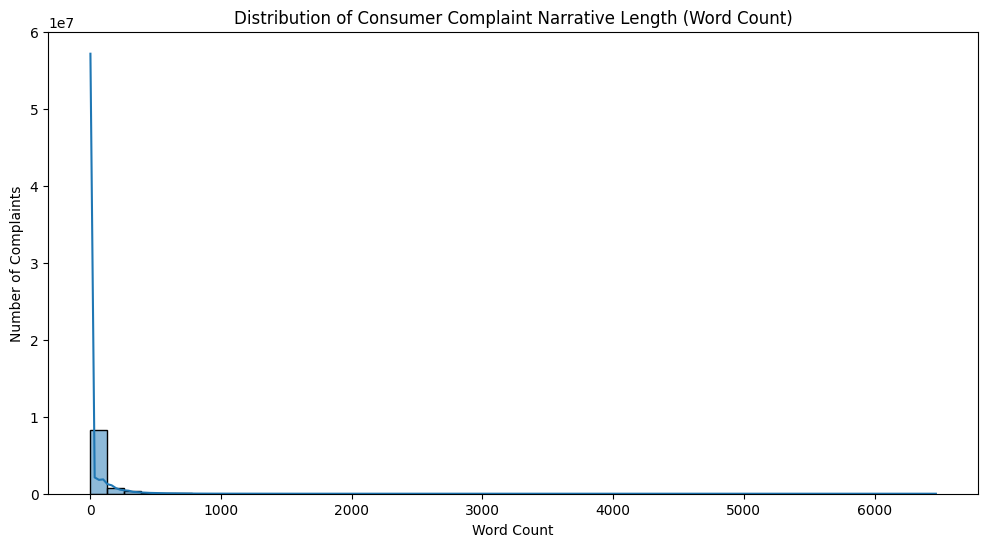


Narrative Length Statistics:
count    9.609797e+06
mean     5.515649e+01
std      1.495169e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_length, dtype: float64

Number of very short narratives (less than 10 words): 6650979

Number of medium narratives 2920582
Number of very long narratives (more than 1000 words): 32428


In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(df['narrative_length'], bins=50, kde=True)
plt.title('Distribution of Consumer Complaint Narrative Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.show()

print("\nNarrative Length Statistics:")
print(df['narrative_length'].describe())

short_threshold = 10
long_threshold = 1000

print(f"\nNumber of very short narratives (less than {short_threshold} words): {((df['narrative_length'] > 0) & (df['narrative_length'] < short_threshold)).sum()}")
print(f"\nNumber of medium narratives {((df['narrative_length'] > short_threshold) & (df['narrative_length'] < long_threshold)).sum()}")
print(f"Number of very long narratives (more than {long_threshold} words): {(df['narrative_length'] > long_threshold).sum()}")

In [10]:
num_with_narrative = df['Consumer complaint narrative'].dropna().apply(lambda x: bool(x.strip())).sum()
num_without_narrative = len(df) - num_with_narrative

print(f"\nNumber of complaints with narratives: {num_with_narrative}")
print(f"Number of complaints without narratives: {num_without_narrative}")



Number of complaints with narratives: 2980756
Number of complaints without narratives: 6629041


In [11]:
df['word_count'] = df['Consumer complaint narrative'].apply(count_words)

# --- Your current filtering steps ---
desired_product_strings = [
    'Payday loan, title loan, personal loan, or advance loan',
    'Payday loan, title loan, or personal loan',
    'Consumer loan',
    'Checking or savings account',
    'Credit card',
    'Money transfer, virtual currency, or money service'
]
df_filtered_products = df[df['Product'].isin(desired_product_strings)].copy()
print(f"1. Records after filtering by products: {len(df_filtered_products)}")

# Remove records with empty narratives (after stripping whitespace)
df_cleaned_empty_removed = df_filtered_products[
    df_filtered_products['Consumer complaint narrative'].astype(str).apply(lambda x: bool(x.strip()))
].copy()
print(f"2. Records after removing empty narratives: {len(df_cleaned_empty_removed)}")

# --- NEW STEP: Remove records below the short threshold (e.g., < 10 words) ---
short_threshold = 10 # Our agreed-upon threshold

df_final_cleaned = df_cleaned_empty_removed[
    df_cleaned_empty_removed['word_count'] >= short_threshold
].copy()
print(f"3. Records after removing narratives with less than {short_threshold} words: {len(df_final_cleaned)}")

print("\nSample of df_final_cleaned (first 5 rows):")
print(df_final_cleaned.head())


1. Records after filtering by products: 710085
2. Records after removing empty narratives: 710085
3. Records after removing narratives with less than 10 words: 342617

Sample of df_final_cleaned (first 5 rows):
      Date received                      Product  \
12237    2025-06-13                  Credit card   
12532    2025-06-13  Checking or savings account   
13280    2025-06-12                  Credit card   
13506    2025-06-12                  Credit card   
13955    2025-06-09                  Credit card   

                                      Sub-product  \
12237                           Store credit card   
12532                            Checking account   
13280  General-purpose credit card or charge card   
13506  General-purpose credit card or charge card   
13955  General-purpose credit card or charge card   

                                                 Issue  \
12237                            Getting a credit card   
12532                              Managi

In [18]:
df = pd.DataFrame(df_final_cleaned)
df.to_csv('../data/filtered_complaints.csv', index=False)
